### Objective
 Organize and analyse data from plate readers experiments. At a initial approach it is to analize inverters genetic circuits. It have to save processed data and be able to work with the full data experiments (not only with one book at time) 

### requirements:
 * have the data organized in a xls file.


In [1]:
# import general packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# import xls manager package manager
import openpyxl as opxl

In [ ]:
# import plate reader data manager package
#import platemanage as plate

Then we are ready to loas the data from the xls book files:

In [3]:
#load the data 
wb = opxl.load_workbook(filename = 'Raw_data/RV1 - python.xlsx')
#get the sheet names
sheets = wb.sheetnames
print(sheets)

# to get a sheet call them as: OD600sheet = wb['OD600']

['Plate 1 - Sheet1', 'OD600', 'CFP', 'YFP', 'Strains', 'Inductor', 'Media']


In [4]:
#dimensionando los datos:
#in the cell mode of datasheet index start from 1 not from 0 as usually in python

def sheet_size(sheet, rc0=[1,1]): 
    """
    This function aims to size the data present in a sheet. The sizing is performed in a fixed position given by the user (rc0).
    It means if rc0=[1,1] the column counting will be done in the first row and the row counting will be done in the first column.
    
    Parameters
    ----------
    sheet: workbook sheet
        sheet file to be sized
    
    rc0: numeric list
        [row number, colmun number] fixed positions where perform the count
        
    
    Returns
    -------        
    rows: integer
        number of rows counted in the sheet
    
    columns: integer
        number of columns counted in the sheet
        
    """
    rows = 1 
    columns = 1
        
    while True:
        if sheet.cell(row=rows+1, column=rc0[1]).value != None: 
            rows+=1
        else:
            break
    while True:
        if sheet.cell(row=rc0[0], column=columns+1).value != None:
            columns+=1
        else:
            break
    #print(str(rows) + ' rows') 
    #print(str(columns) + ' columns')
    return(rows,columns)

We are interested in the size of the sheets OD600, YFP and CFP (and will call them *data_sheets*)

In [5]:
data_sheets = sheets[1 : 4]
for namesheet in data_sheets:
    print(namesheet+': ')
    print(sheet_size(wb[namesheet]))
    print('\n')

OD600: 
(146, 98)


CFP: 
(146, 98)


YFP: 
(146, 98)




The data in the sheets include headers and specials columns as _Time_ and _Temperature_. To split them we have to indicate the position where wells data start.

In [6]:
start_row=input('Enter the data starting row number ')
print('data start in row '+ start_row) # 2
start_column=input('Enter the data starting column number ')
print('data start in column '+ start_column) # 3

Enter the data starting row number 2
data start in row 2
Enter the data starting column number 3
data start in column 3


With this values we are able to determine the real size of the data wells:

In [7]:
srow=int(start_row)
scolumn=int(start_column)

ncolumns=sheet_size(wb[sheets[1]])[1]- scolumn + 1
print('wells = ' + str(ncolumns) )
timepoints=sheet_size(wb[sheets[1]])[0]- srow + 1
print('time points = ' + str(timepoints))

wells = 96
time points = 145


Now we should be able to get the values of each dataset

In [8]:
def get_values(ws, row_start, column_start, time_column=1, header_row=1):
    """
    To get the wells data from a worksheet
    
    Parameters
    ----------
    ws: worksheet
        sheet file to get the data
    
    row_start: int
        row where wells data started
        
    
    Returns
    -------
    data: numpy array
        wells experimental measurements
        
    time: numpy vector
        time points values in hours units
    
    header: str
        header of each well data (usually 'A1','A2', etc)
        
    """
    
    rows, columns=sheet_size(ws)    
    data= np.zeros((rows-row_start+1,columns-column_start+1))
    time = np.zeros((rows-row_start+1))
    headers = []
    for i in range(rows-row_start+1):
        
        time_aux = ws.cell(row=i+row_start, column=time_column).value
        
        #transform time values in hour fractions units
        if type(time_aux)==float:
            time[i] = time_aux*24
        else:
            time[i] =time_aux.hour + time_aux.minute/60 + time_aux.second/3600
            
                
        for j in range(columns-column_start+1):
            data[i,j]=ws.cell(row=i+row_start, column=j+column_start).value
            if i==0:
                headers.append(ws.cell(row=header_row, column=j+column_start).value)  # list with the headers
    #print(headers)
    return(data,time,headers)

In [167]:
wdata={}
for namesheet in data_sheets:
    wdata[namesheet] = {} 
    data, time, header = get_values(wb[namesheet],srow,scolumn,1,1)
    wdata[namesheet]['data'] = data
    wdata[namesheet]['time'] = time
    wdata[namesheet]['header'] = header
    

Be carefull at get the size of header, beacause it is a list and then you have to use `len()` to know his shape

In [120]:
print(wdata[data_sheets[1]]['data'].shape)
print(wdata[data_sheets[1]]['time'].shape[0])
print(len(wdata[data_sheets[1]]['header']))

(145, 96)
145
96


Now, we should get the different labels assigned to each well:

In [11]:
def get_label_values(ws,row_start,column_start):
    rows,columns=sheet_size(ws)    
    if type(ws.cell(row=row_start, column=column_start).value) == str:
        values = []
        for i in range(rows-row_start+1):
            values_col=[]         
            for j in range(columns-column_start+1):
                values_col.append(ws.cell(row=i+row_start, column=j+column_start).value)
            values.append(values_col)  
    
    else:   #in case data is not string
        values= np.zeros((rows-row_start+1,columns-column_start+1))
    
        for i in range(rows-row_start+1):
                      
            for j in range(columns-column_start+1):
                values[i,j]=ws.cell(row=i+row_start, column=j+column_start).value

    return(values)    

In [12]:
L_start_row=input('Enter the label starting row number ')
print('data start in row '+ L_start_row) # 2
L_start_column=input('Enter the label starting column number ')
print('data start in column '+ L_start_column) # 2

Enter the label starting row number 2
data start in row 2
Enter the label starting column number 2
data start in column 2


And as we could expect, it is 8 by 12 size

In [13]:
print(len(get_label_values(wb[sheets[4]],int(L_start_row),int(L_start_column))))
print(len(get_label_values(wb[sheets[4]],int(L_start_row),int(L_start_column))[1]))

8
12


In [14]:
# labels are in:
L_sheets=sheets[4:]
print(L_sheets)

['Strains', 'Inductor', 'Media']


In [15]:
wlabels={}
for namesheet in L_sheets:
    wlabels[namesheet] = get_label_values(wb[namesheet],int(L_start_row),int(L_start_column))   

In [16]:
wlabels[L_sheets[0]]

[['pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan'],
 ['pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan'],
 ['pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan'],
 ['pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan'],
 ['pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',


Now, we can start to plot the data:

In [17]:
wdata[data_sheets[0]]['time']

array([  0.125     ,   0.29166667,   0.45833333,   0.625     ,
         0.79166667,   0.95833333,   1.125     ,   1.29166667,
         1.45833333,   1.625     ,   1.79166667,   1.95833333,
         2.125     ,   2.29166667,   2.45833333,   2.625     ,
         2.79166667,   2.95833333,   3.125     ,   3.29166667,
         3.45833333,   3.625     ,   3.79166667,   3.95833333,
         4.125     ,   4.29166667,   4.45833333,   4.625     ,
         4.79166667,   4.95833333,   5.125     ,   5.29166667,
         5.45833333,   5.625     ,   5.79166667,   5.95833333,
         6.125     ,   6.29166667,   6.45833333,   6.625     ,
         6.79166667,   6.95833333,   7.125     ,   7.29166667,
         7.45833333,   7.625     ,   7.79166667,   7.95833333,
         8.125     ,   8.29166667,   8.45833333,   8.625     ,
         8.79166667,   8.95833333,   9.125     ,   9.29166667,
         9.45833333,   9.625     ,   9.79166667,   9.95833333,
        10.125     ,  10.29166667,  10.45833333,  10.62

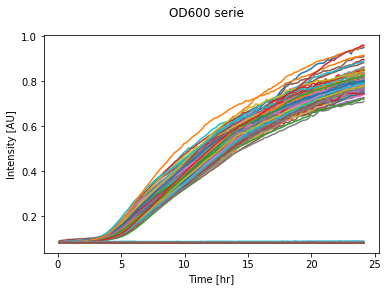

In [18]:
# put here the data name you are interested
data_name=data_sheets[0]    #only change the number inside []

# now it will be plot
fig= plt.figure()
fig.suptitle(data_name +' serie')
plt.plot(wdata[data_name]['time'], wdata[data_name]['data'])
plt.ylabel('Intensity [AU]')
plt.xlabel('Time [hr]')
#plt.axis([0, 6, 0, 20])
plt.show()

Support Function

In [19]:
def non_redundant_list(labels):
    # make a list of non-redundant labels
    nr_labels=[]
    for label in labels:
        if label not in nr_labels:
            nr_labels.append(label)
    return(nr_labels)

In [20]:
def get_labelstrings(wsl, index_label, index, label_cathegories):
    # get the labels of the selected wells - datasets
    # index = well index number
    label_string=''
    for cat in label_cathegories:

        label_name = str(wsl[cat][index_label[index][0]][index_label[index][1]])
                
        if label_string == '':
            label_string = label_name
        else:
            label_string = label_string + ' , ' + label_name
        
    return(label_string)
            

In [21]:
def plot_group(wsd, wsl, datasheets, index_data, index_label, label_cath, y_axis_labels, log = False):
    """
    Plot the data from 'wsd' of wells indicated on 'index_data' putting the labels from 'label_cath' whos positions
    are indicated in 'index_label'.  
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    wsl:dictionary
        contain the labels of each well
        
    datasheets: list
        list of datasheet names. If you only put one name, make sure to make it a list
        e.g. ['sheet_name'] and not only 'sheetname'
    
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    index_label: list
        coordinates of the selected wells in the label sheets
        can be obtained with get_group_index or set manually
    
    label_cath: list
        sheet names of the cathegories to use in the labels
    
    y_axis_labels: list
        y axis labels to write in the plots. It have to be in the same order
        as the data is included. 
        e.g: y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']
        
    
    Returns
    -------
    Plots of the desired data
        
    """
        
    data = {}
    labels = []
    ind_len = len(index_data)
    
    for name in datasheets:
        # make a list with arrays of zeros with the size of each dataset
        data[name] = np.zeros((wsd[name]['time'].shape[0], ind_len))

        # assign the corresponding values to each array
        for i in range(ind_len):
            data[name][:,i]=wsd[name]['data'][:,index_data[i]]
            
            # get the labels of the selected wells - datasets
            labels.append(get_labelstrings(wsl, index_label, i, label_cath))   
        
    print(labels)
    # make a list of non-redundant labels
    nr_labels = non_redundant_list(labels)

    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    # make plots
   
    for name,m in zip(datasheets, range(len(y_axis_labels))):
        fig= plt.figure()
        fig.suptitle(name + ' series')
        plot_lines = []
        time=wsd[name]['time']
        
        for j in range(ind_len):
            lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
            p=plt.plot(time, data[name][:,j], color=colors[lab_num])
            plot_lines.append(p)
        
        plt.ylabel(y_axis_labels[m])
        plt.xlabel('Time [hr]')
        if log == True:
            plt.yscale('log')
        #plt.axis([0, 6, 0, 20])
        plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
        plt.show()

It's neccesary to define the blank data sets for OD600 and fluorescence to substract them to the rest of the data:

In [22]:
def get_group_index(label_groups, wsl, label_sheetnames):
    """
    Return the data index (well number) and the label index (label position) of the
    wells whose label coincide with at least one label of 'label_groups' (OR logic)
    In the future should be modified to choose between OR / AND logic classification
    accord the groups indicated in 'label_groups'
    
    Parameters
    ----------
    label_groups: list of strings
        contain the cathegories whose data sets are desired to select
        
    wsl: dictionary
        cointain the data from the workbook label sheets
    
    label_sheetnames: list of strings
        contain the names of the sheets with the labels
        
    
    Returns
    -------
    index_data: list
        contain the index of the selected data wells
        
    index_label: list
        coordinates of the selected wells in the label sheets
        
    """
    index_data=[]
    index_label=[]

    for cat in label_groups:
        for name in label_sheetnames:
            counter=0
            labels = wsl[name]
            for i in range(len(labels)):
                for j in range(len(labels[0])):
                    if cat == labels[i][j]:
                        index_data.append(counter)
                        index_label.append([i,j])
                    counter+=1    
    print(index_data)
    print(index_label)
    return(index_data, index_label)

In [23]:
def get_group_values(wsd, sheetnames, index_data, index_label):
    """
    Get the values of desired set of wells
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    sheetnames: list
        names of the data sheets
        
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    
    Returns
    -------
    data: dictionary
        data of the desired wells. 
        Its estructure is: data[sheetname]['data' or 'time'] 
        
    """
    data = {}
    ind_len = len(index_data)
    
    for name in sheetnames:
        data[name] = {}
        
        data[name]['time'] = wsd[name]['time']
        data[name]['data'] = np.zeros((wsd[name]['time'].shape[0], ind_len))
        
        for i in range(ind_len):
            data[name]['data'][:,i]=wsd[name]['data'][:,index_data[i]]

    data['index'] = index_data
    data['index_lab'] = index_label
    return(data) 

[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[[7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [7, 11]]
['Blanco , 1000.0', 'Blanco , 200.0', 'Blanco , 100.0', 'Blanco , 50.0', 'Blanco , 10.0', 'Blanco , 0.0', 'Blanco +Kan , 1000.0', 'Blanco +Kan , 200.0', 'Blanco +Kan , 100.0', 'Blanco +Kan , 50.0', 'Blanco +Kan , 10.0', 'Blanco +Kan , 0.0']


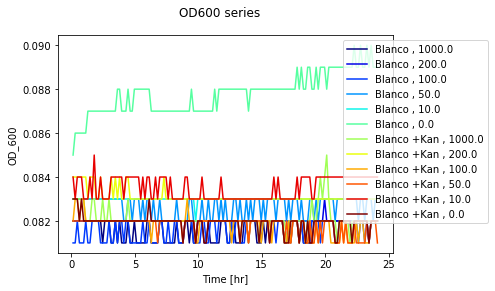

In [24]:
#define the OD blank data series
B_labels=['Blanco','Blanco +Kan']  #fill this list manually

# and get the wells index which have that lalbels
index_D, index_L = get_group_index(B_labels, wlabels, L_sheets)

#Perform the plots of blank series data
legend_labels = [L_sheets[0], L_sheets[1]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdata, wlabels, [data_sheets[0]], index_D, index_L, legend_labels, y_axis_labels)


As the OD blank values (given by the empty media) are tiny and roughtly constants, it's possible to condense them as only one value given by the mean of all of them.

In [26]:
OD_blank_val = get_group_values(wdata, data_sheets, index_D, index_L)
print(OD_blank_val['OD600']['data'].shape)

OD_bval=OD_blank_val['OD600']['data'].mean(axis=(0,1))
print(OD_bval)

(145, 12)
0.0827385057471


Then, substract the blank value:

In [27]:
OD_blank_val['OD600']['data'][1,:]

array([ 0.082,  0.082,  0.081,  0.083,  0.083,  0.086,  0.083,  0.084,
        0.083,  0.082,  0.083,  0.083])

In [28]:
def subtract_OD_blank(wsd, od_sheet_name, blank_value):
    od600 = wsd[od_sheet_name]['data']
    od600 = od600 - blank_value
    
    for i in range(od600.shape[0]):
        for j in range(od600.shape[1]):
            if od600[i,j] < 0.0005:
                od600[i,j] = 0.0005    # the minimum value is set to be 0.005 (as we start from 1:1000 bacterial dilution)
    return(od600)

Perform the substraction (make sure to only run it once)

In [30]:
wdataB = wdata

In [31]:
wdataB['OD600']['data'] = subtract_OD_blank(wdata, data_sheets[0], OD_bval)


In [32]:
np.min(wdataB['OD600']['data'])

0.00050000000000000001

Now it's necessary to compute the fluorescent blank values. For this aim, we need to  analyse the 'Fluorescent blank series' which in this case are TOP10

In [33]:
#define the Fluorescent blank data series
FB_labels=['TOP10']  #fill this list manually

[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
[[6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11]]
['TOP10 , 1000.0', 'TOP10 , 200.0', 'TOP10 , 150.0', 'TOP10 , 100.0', 'TOP10 , 70.0', 'TOP10 , 50.0', 'TOP10 , 40.0', 'TOP10 , 30.0', 'TOP10 , 20.0', 'TOP10 , 10.0', 'TOP10 , 5.0', 'TOP10 , 0.0', 'TOP10 , 1000.0', 'TOP10 , 200.0', 'TOP10 , 150.0', 'TOP10 , 100.0', 'TOP10 , 70.0', 'TOP10 , 50.0', 'TOP10 , 40.0', 'TOP10 , 30.0', 'TOP10 , 20.0', 'TOP10 , 10.0', 'TOP10 , 5.0', 'TOP10 , 0.0', 'TOP10 , 1000.0', 'TOP10 , 200.0', 'TOP10 , 150.0', 'TOP10 , 100.0', 'TOP10 , 70.0', 'TOP10 , 50.0', 'TOP10 , 40.0', 'TOP10 , 30.0', 'TOP10 , 20.0', 'TOP10 , 10.0', 'TOP10 , 5.0', 'TOP10 , 0.0']


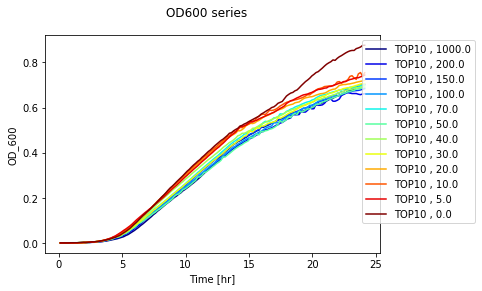

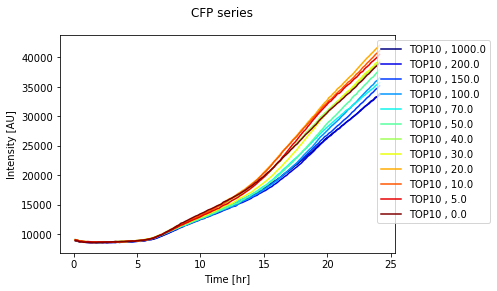

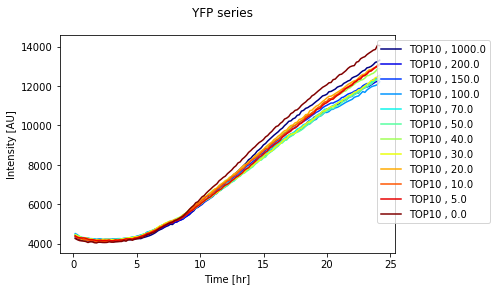

In [34]:
# and get the wells index which have that lalbels
index_D, index_L = get_group_index(FB_labels, wlabels, L_sheets)

#Perform the plots of blank series data
legend_labels = [L_sheets[0], L_sheets[1]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdataB, wlabels, data_sheets, index_D, index_L, legend_labels, y_axis_labels)


And get the values of those data

In [35]:
Fluo_Blank = get_group_values(wdataB, data_sheets, index_D, index_L)

Now we should get an empiric funtion to relate growth and basal fluorescent signal

In [36]:
def plot_dat_dat(wsd, x_sheetname, y_sheetname, x_units, y_units, label_cath, wsl, index_dat = '', index_lab = ''):
    
    # define the well data index and well label index
    if index_dat == '': 
        wells = wsd['index']
    else:
        wells = index_dat
        
    if index_lab == '':
        index_label = wsd['index_lab']
    else:
        index_label = index_lab
    
    if len(wells) != len(index_label):
        print('ERROR: Wells index data and wells index label have to be same length!')
        return
    
    # get the data
    labels = []
    wells_num = len(wsd[x_sheetname]['data'][0,:])
    data = np.zeros((len(wsd[x_sheetname]['data'][:,0]), 2, wells_num))
        
    for i in range(wells_num):

        data[:,0,i] = wsd[x_sheetname]['data'][:,i]
        data[:,1,i] = wsd[y_sheetname]['data'][:,i]
        labels.append(get_labelstrings(wsl, index_label, i, label_cath))   
    
    # make a list of non-redundant labels
    nr_labels = non_redundant_list(labels)

    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    fig= plt.figure()
    fig.suptitle(x_sheetname + ' v/s '+ y_sheetname)
   
    for j in range(wells_num):
        lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
        p=plt.plot(data[:,0,j], data[:,1,j], color=colors[lab_num])
    
    plt.ylabel(y_sheetname +' '+ str(y_units))
    plt.xlabel(x_sheetname +' '+ str(x_units))
    plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
    #plt.axis([0, 6, 0, 20])
    plt.show()
    
    return(data)



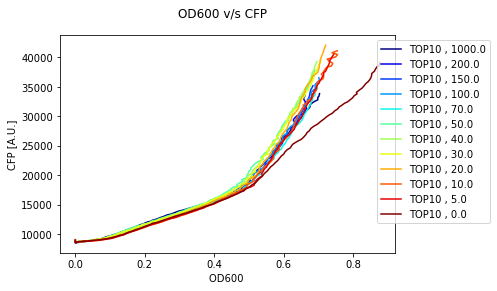

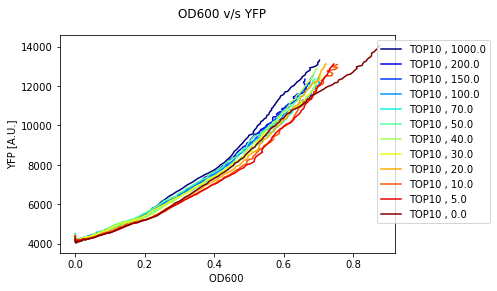

In [37]:
legend_labels = [L_sheets[0], L_sheets[1]]
_ = plot_dat_dat(Fluo_Blank,'OD600','CFP', '','[A.U.]', legend_labels, wlabels)
_ = plot_dat_dat(Fluo_Blank,'OD600','YFP', '','[A.U.]', legend_labels, wlabels)

We can fit an empiric polynomial function to this values using 'polyfit'. To this aim it's necessary to have all the data in one sorted matrix (otherwise fitting makes weird wheels).

In [38]:
def sort_matrix(data, col_name):
    # sort the values
    # scol = column used to determine the sorting
    # data: dictionary which contains:
    #      'matrix' = matrix to be sorted
    #      'column_names' = matrix to be sorted
    # matrix_sort_col = matrix sorted based on the 'scol' column
    
    scol=data['column_names'].index(col_name)
    matrix = data['matrix']
    
    # perform the matrix sorting
    matrix_sort_col = np.zeros((matrix.shape))
    matrix_sort = np.sort(matrix,0)  # each column is sorted independently

    for i in range(matrix_sort.shape[0]):
        for j in range(matrix.shape[0]):
                   
            if matrix_sort[i,scol] == matrix[j,scol]:
                matrix_sort_col[i,:] = matrix[j,:]
                matrix = np.delete(matrix, j, 0)
                break
    
    # store the data
    sorted_data = data
    sorted_data['matrix'] = matrix_sort_col
    return(sorted_data)

In [39]:
def group_sheet_values(wells_data, data_sheets):
    # this function put all the data of data_sheets on one matrix, where each sheet is put in a colum (data of
    # each well is one under other on the same column) with length = wells number * time points.
    # wells_data = matrix with the data of wells in each column. e.g. = data['OD600']['data'].shape[0]
    # data_sheets: data sheet labels list. e.g ['OD600','CFP','YFP']
    
    group_data={}
    times = wells_data[data_sheets[0]]['data'].shape[0]
    wells = wells_data[data_sheets[0]]['data'].shape[1]

    group_data['matrix'] = np.zeros((times*wells,len(data_sheets)))
    for i in range(wells):
        for j in range(len(data_sheets)):
            group_data['matrix'][i*times:(i+1)*times,j]=wells_data[data_sheets[j]]['data'][:,i]
    
    group_data['column_names'] = data_sheets
    
    return(group_data)

Perform the data sorting

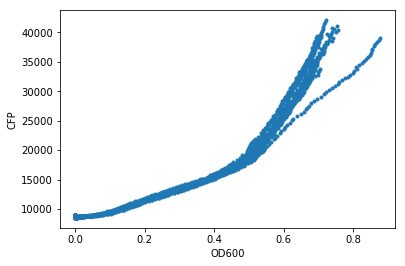

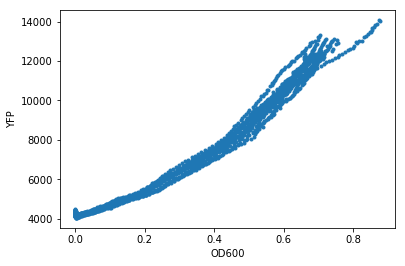

In [40]:
FB_matrix = group_sheet_values(Fluo_Blank, data_sheets)

# sort the values
FB_sort_matrix = sort_matrix(FB_matrix, data_sheets[0])

# sorted plot
sheetx = data_sheets[0]
sheety = data_sheets[1]
sheetx_index = FB_sort_matrix['column_names'].index(sheetx)
sheety_index = FB_sort_matrix['column_names'].index(sheety)
fig= plt.figure()
plt.plot(FB_sort_matrix['matrix'][:,sheetx_index],FB_sort_matrix['matrix'][:,sheety_index],'.')
plt.ylabel(sheety)
plt.xlabel(sheetx)
plt.show()

sheetx = data_sheets[0]
sheety = data_sheets[2]
sheetx_index = FB_sort_matrix['column_names'].index(sheetx)
sheety_index = FB_sort_matrix['column_names'].index(sheety)
fig= plt.figure()
plt.plot(FB_sort_matrix['matrix'][:,sheetx_index],FB_sort_matrix['matrix'][:,sheety_index],'.')
plt.ylabel(sheety)
plt.xlabel(sheetx)
plt.show()

Try fitting with an example data well

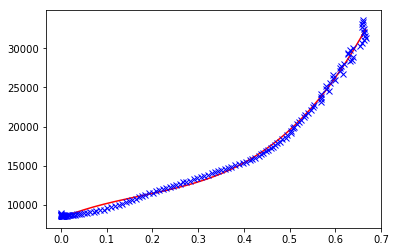

In [41]:
A=Fluo_Blank['OD600']['data'][:,1]
B=Fluo_Blank['CFP']['data'][:,1]
z=np.polyfit(A,B,3)
Fluo_Blank['CFP']['fit_func']=np.poly1d(z)

fig= plt.figure()
plt.plot(A,Fluo_Blank['CFP']['fit_func'](A),color='r')
plt.plot(A,B,'x',color='b')
plt.show()

Perform the data fitting

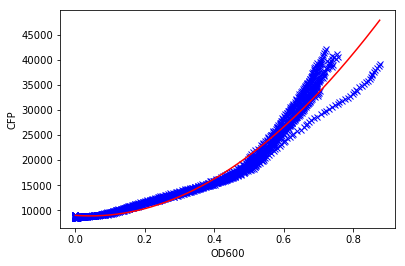

In [42]:
# Inputs
sheetx = data_sheets[0]
sheety = data_sheets[1]
sheetx_index = FB_sort_matrix['column_names'].index(sheetx)
sheety_index = FB_sort_matrix['column_names'].index(sheety)
pol_degree = 3

# fitting
X=FB_sort_matrix['matrix'][:,sheetx_index]
Y=FB_sort_matrix['matrix'][:,sheety_index]
z=np.polyfit(X,Y,pol_degree)
function_name = 'f('+sheetx+')'
Fluo_Blank[sheety][function_name]=np.poly1d(z)

# plot
fig= plt.figure()
plt.plot(X,Y,'x',color='b')
plt.plot(X,Fluo_Blank[sheety][function_name](X),color='r')
plt.ylabel(sheety)
plt.xlabel(sheetx)
plt.show()

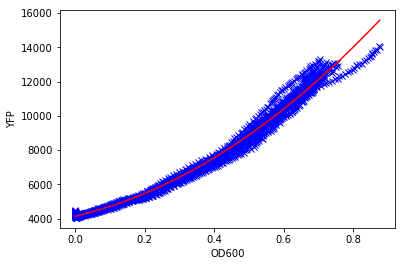

In [43]:
# Inputs
sheetx = data_sheets[0]
sheety = data_sheets[2]
sheetx_index = FB_sort_matrix['column_names'].index(sheetx)
sheety_index = FB_sort_matrix['column_names'].index(sheety)
pol_degree = 2

# fitting
X=FB_sort_matrix['matrix'][:,sheetx_index]
Y=FB_sort_matrix['matrix'][:,sheety_index]
z=np.polyfit(X,Y,pol_degree)
function_name = 'f('+sheetx+')'
Fluo_Blank[sheety][function_name]=np.poly1d(z)

# plot
fig= plt.figure()
plt.plot(X,Y,'x',color='b')
plt.plot(X,Fluo_Blank[sheety][function_name](X),color='r')
plt.ylabel(sheety)
plt.xlabel(sheetx)
plt.show()

Lo que viene ahora es restar estos valores a los de fluorescencia y luego hacer los analisis ratiometric :)

In [44]:
wdataB['CFP']['data']

array([[   9139.,    9086.,    9051., ...,    8939.,    8900.,    8938.],
       [   8999.,    8984.,    8913., ...,    8786.,    8790.,    8780.],
       [   8879.,    8926.,    8817., ...,    8716.,    8681.,    8728.],
       ..., 
       [ 102263.,  102352.,  102448., ...,    8768.,    8791.,    8936.],
       [ 102957.,  103008.,  103325., ...,    8793.,    8796.,    8957.],
       [ 103846.,  103995.,  104384., ...,    8787.,    8778.,    8946.]])

In [45]:
def subtract_fluo_blank(wsd, fluo_blank, y_sheet_names, xsheet, plot = True):
    
    xdat = wsd[xsheet]['data']
    
    for sheet in y_sheet_names:
        ydat = wsd[sheet]['data']
        
        # evaluate the fluo blank function in each xdata point
        yblank = fluo_blank[sheet]['f('+xsheet+')'](xdat)
        ysub=np.zeros((yblank.shape))
        
        # perform the substraction
        for i in range(yblank.shape[0]):
            for j in range(yblank.shape[1]):
                ysub[i,j] = ydat[i,j] - yblank[i,j]
                
                # make sure any value is under 1
                if ysub[i,j] < 1:
                    ysub[i,j] = 1
        
        # replace the new computed value in the data dictionary
        wsd[sheet]['data'] = ysub
        
        # make the plot if it is desired
        if plot == True:
            pdat = plt.plot(xdat,ydat,'b')
            pblank = plt.plot(xdat,yblank,'g')
            psub = plt.plot(xdat,ysub,'r')
            plt.xlabel(xsheet)
            plt.ylabel(sheet)
            plt.title(sheet)
            plt.legend((pdat[0], pblank[0], psub[0]), ('Data', 'Blank', 'Blank subtracted'))
            plt.show()
        
    return(wsd)
        

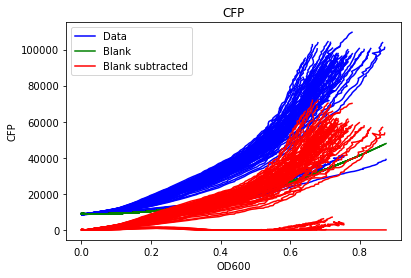

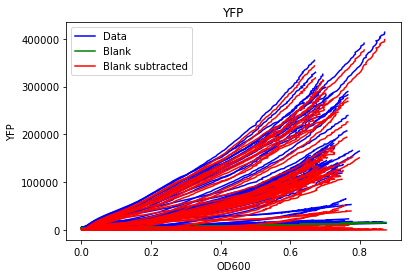

In [46]:
wdata2=subtract_fluo_blank(wdataB, Fluo_Blank, ['CFP','YFP'], 'OD600')  # wdara2 now contain the values in red lines

At this point we should save this data in a new file... because this is the end of data manipulation and start the real analysis....

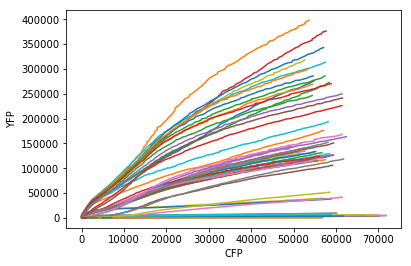

In [47]:
# make a ratiometric general view
for i in range(wdata2['CFP']['data'].shape[1]):
    plt.plot(wdata2['CFP']['data'][:,i],wdata2['YFP']['data'][:,i])

plt.ylabel('YFP')
plt.xlabel('CFP')
plt.show()


In [ ]:
plot_dat_dat(wsd, x_sheetname, y_sheetname, x_units, y_units, label_cath, wsl, index_dat = '', index_lab = ''):

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11]]


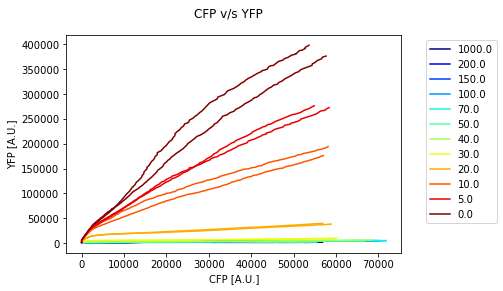

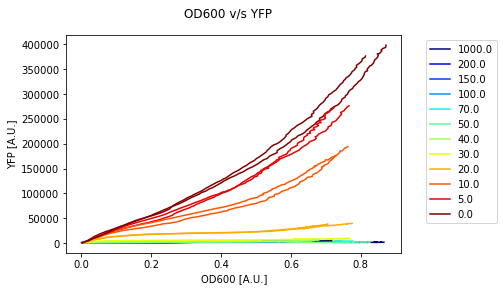

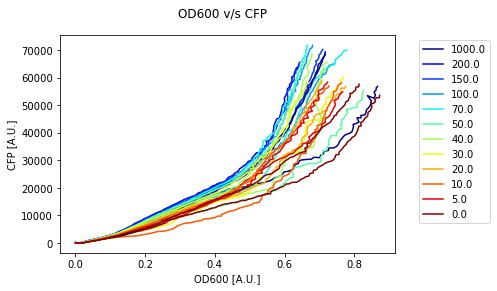

In [113]:
srp_labels=['pSrpR-S3_cyan']

# and get the wells index which have that lalbels
index_D, index_L = get_group_index(srp_labels, wlabels, L_sheets)

# get its data
srp = get_group_values(wdata2, data_sheets, index_D, index_L) #now use wdata2

#perform its plots
legend_labels = [L_sheets[1]]
_ = plot_dat_dat(srp,'CFP','YFP', '[A.U.]','[A.U.]', legend_labels, wlabels)
_ = plot_dat_dat(srp,'OD600','YFP', '[A.U.]','[A.U.]', legend_labels, wlabels)
_ = plot_dat_dat(srp,'OD600','CFP', '[A.U.]','[A.U.]', legend_labels, wlabels)

['1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0', '1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0', '1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0', '1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0', '1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0', '1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0']


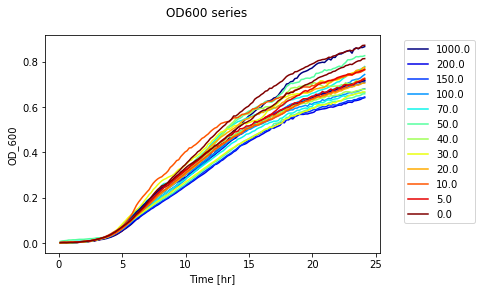

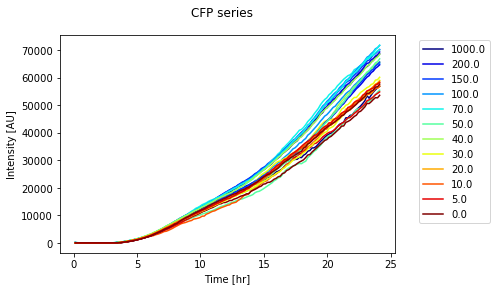

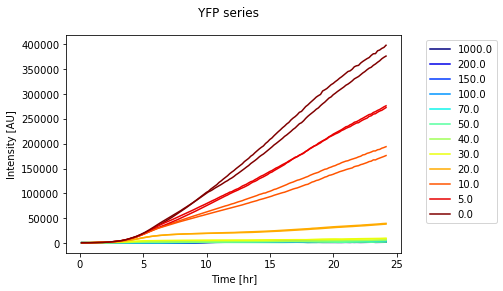

In [49]:
#Perform plots in time
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']
plot_group(wdata2, wlabels, data_sheets, index_D, index_L, legend_labels, y_axis_labels)

Encontrar los tiempos en que es exponencial el crecimiento, hacer curve fittings (probablemente spline lines) y luego calcular los ratios. Además es necesario poner identificadores a cada pocillo para saber si son replicas o no (ya está para plots, pero para marcar los datos como replicas. Esta función está en el antiguo plate reader analysis)

['1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0', '1000.0', '200.0', '150.0', '100.0', '70.0', '50.0', '40.0', '30.0', '20.0', '10.0', '5.0', '0.0']


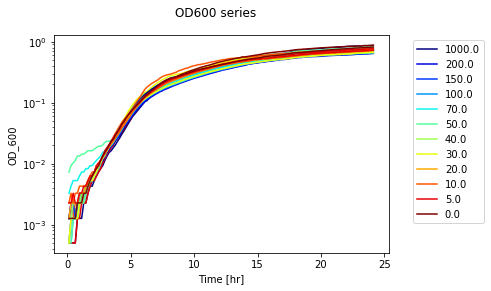

In [50]:
#Perform plots in time
y_axis_labels = ['OD_600']
plot_group(wdata2, wlabels, ['OD600'], index_D, index_L, legend_labels, y_axis_labels,log=True)

The exponencial growth phase correspond to the time period where $ ln(A) = \mu * t + ln(A_0) $ (i.e. where $ln(A)$ is lineal)

In [111]:
log_od=np.log(srp['OD600']['data'])

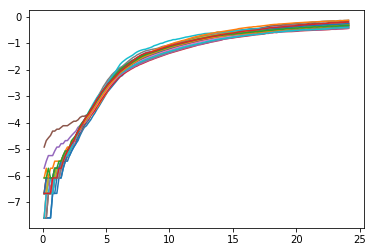

In [124]:
plt.plot(srp['OD600']['time'],log_od)
plt.show()

Let's compute $\mu = 1/A * dA/dt $ . As a first approach let's do it without fitting

In [53]:
# compute 1/A
A_inv = np.ones((srp['OD600']['data'].shape[0],srp['OD600']['data'].shape[1]))
A_inv = np.divide(A_inv,srp['OD600']['data'])

In [56]:
np.min(srp['OD600']['data'])
np.min(A_inv)

1.146445196295796

In [72]:
# anyway, make sure A_inv don't have values less than 1 (otherwise will make problems with the computations)
A_inv[A_inv < 1] = 1

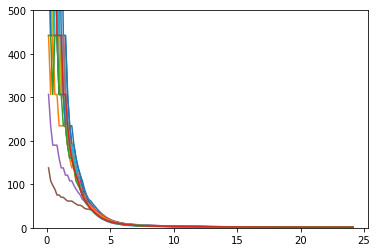

In [77]:
plt.plot(srp['OD600']['time'], A_inv)
plt.ylim([0,500])
plt.show()

In [78]:
# compute the derivative
dA = np.diff(srp['OD600']['data'],axis=0)
dT = np.diff(srp['OD600']['time'],axis=0)
dT_matrix = np.zeros((dA.shape[0],dA.shape[1]))
for i in range(dA.shape[1]):
    dT_matrix[:,i] = dT

dAdT_dis = np.divide(dA,dT_matrix)

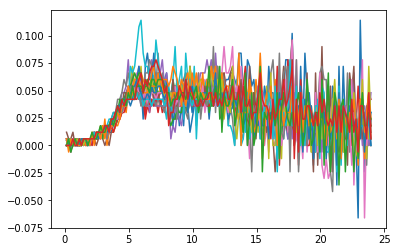

In [79]:
# make the plot
plt.plot(srp['OD600']['time'][0:-1], dAdT_dis)
plt.show()

The beggining seems to be too noisy.... maybe is better to fit a curve before...

In [198]:
def f_3_lines(x, *p):
    # three different strighlines with variable domains
    # p = [t1,t2,m1,m2,m3,b1,b2,b3]
    
    y = np.zeros((x.shape))  # only to init "y"
    
    for i in range(len(x)):
    
        if x[i] <= p[0]:
            y[i] = p[2] * x[i] + p[5]
            
        elif x[i] <= p[1]:
            y[i] = p[3] * x[i] + p[6]
        
        else:
            y[i] = p[4] * x[i] + p[7]
            
    return(y)    
        

In [89]:
from scipy import optimize

In [97]:
# define the error function
errfunc = lambda p, x, y: f_3_lines(p, x) - y

#Perform the fitting
p0 = [20,70,10,1,0.2,-10, -7, -2]      # p = [t1,t2,m1,m2,m3,b1,b2,b3]
wells = srp['OD600']['data'].shape[1]
p1 = np.zeros((len(p0),wells))
success = {}
evalf = np.zeros((srp['OD600']['data'].shape[0], wells))
for i in range(wells):
    p1[:,i], success[i] = optimize.leastsq(errfunc, p0[:], args=(srp['OD600']['time'],log_od[:,i]))
    evalf[:,i] = f_3_lines(p1[:,i], srp['OD600']['time']) 

C:\Users\Prosimio\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


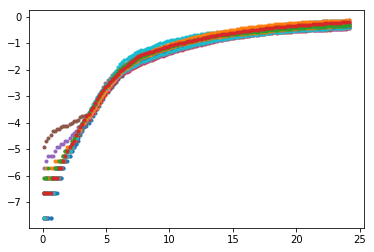

In [127]:
# make the fitting plot
plt.plot(srp['OD600']['time'], log_od, '.')
plt.plot(srp['OD600']['time'], evalf, '-')
plt.show()

In [175]:
time =  wdata['OD600']['time']

In [170]:
time

array([  0.125     ,   0.29166667,   0.45833333,   0.625     ,
         0.79166667,   0.95833333,   1.125     ,   1.29166667,
         1.45833333,   1.625     ,   1.79166667,   1.95833333,
         2.125     ,   2.29166667,   2.45833333,   2.625     ,
         2.79166667,   2.95833333,   3.125     ,   3.29166667,
         3.45833333,   3.625     ,   3.79166667,   3.95833333,
         4.125     ,   4.29166667,   4.45833333,   4.625     ,
         4.79166667,   4.95833333,   5.125     ,   5.29166667,
         5.45833333,   5.625     ,   5.79166667,   5.95833333,
         6.125     ,   6.29166667,   6.45833333,   6.625     ,
         6.79166667,   6.95833333,   7.125     ,   7.29166667,
         7.45833333,   7.625     ,   7.79166667,   7.95833333,
         8.125     ,   8.29166667,   8.45833333,   8.625     ,
         8.79166667,   8.95833333,   9.125     ,   9.29166667,
         9.45833333,   9.625     ,   9.79166667,   9.95833333,
        10.125     ,  10.29166667,  10.45833333,  10.62

In [173]:
values3lines = f_3_lines(p0, time)

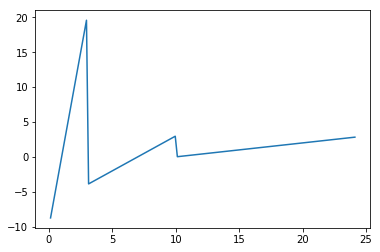

In [174]:
plt.plot(time,values3lines)
plt.show()

In [143]:
p0 = [3,10,10,1,0.2,-10, -7, -2]

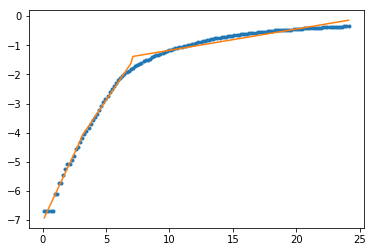

[ 3.          7.          0.93143771  0.6453139   0.07310462 -7.04563156
 -6.11685671 -1.904074  ]


In [179]:
# define the error function
errfunc = lambda p, x, y: f_3_lines(p, x) - y
well_num = 2
#Perform the fitting
p0 = [3,7,10,1,0.2,-10, -7, -2]      # p = [t1,t2,m1,m2,m3,b1,b2,b3]
p1, success = optimize.leastsq(errfunc, p0[:], args=(srp['OD600']['time'],log_od[:,well_num]))
evalf = f_3_lines(p1, srp['OD600']['time']) 

plt.plot(srp['OD600']['time'], log_od[:,well_num],'.')
plt.plot(srp['OD600']['time'],evalf,'-')
plt.show()
print(p1)

In [200]:
#Perform the fitting
srp_lines=function_fit(srp['OD600']['time'],log_od[:,3:4], func = f_3_lines, param0 = p0, param_bounds = ([1,2,0.1,0.1,0.1,-100, -100, -100],[7,15,100,100,100,0, 0, 0]))

plt.plot(srp['OD600']['time'], log_od[:,well_num],'.')
plt.plot(srp['OD600']['time'],srp_lines['evalF'],'-')
plt.show()
print(srp_lines['z'])

[ 3.          6.14161971  1.10405292  0.72202967  0.1        -7.46199001
 -6.41897937 -2.3584821 ]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [136]:
srp['OD600']['time'] = wdata['OD600']['time']

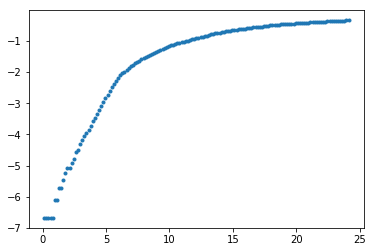

In [137]:
plt.plot(srp['OD600']['time'], log_od[:,2], '.')
plt.show()

In [ ]:
# Fit the first set
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [-15., 0.8, 0., -1.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))

time = np.linspace(Tx.min(), Tx.max(), 100)
plt.plot(Tx, tX, "ro", time, fitfunc(p1, time), "r-") # Plot of the data and the fit

In [189]:
def f_sigma(t, p):
    """
    Compute the sigmoide function value using the given input values
    
    Parameters
    ----------
        t: vector
            independent variable ( "x axis", suposed to be time) 
        
        p: vector
            parameters. it have to include:
            
            p[0]: double
                f asymptotic value

            p[1]: double
                delay parameter
                when f=a/2 then t = -b

            p[2]: double
                slope parameter
        
    Returns
    -------
    function evaluation
    
    """
    return((p[0] /(1+np.exp(-(t+p[1])*p[2]))))
    #return((a /(1+np.exp(-(t+b)*c)))+d)    


In [196]:
def function_fit(xdata, ydata, init=0, end=-1, func=f_sigma, param0 = [1,1,1],
                 param_bounds=([0,-np.inf,0.01],[np.inf,-1,1])):
    """
    Fit a given function to given data
    
    Parameters
    ----------
        xdata: vector
            independent variable ( "x axis", suposed to be time vector) 
        
        ydict: array like
            array of dependent variable vectors 
        
        init: double
            point on the time vector to init the fitting
            
        end: double
            point on the time vector to end the fitting
        
        func: function
            function to be fitted
        
        param_bounds: array of vectors
            lower and upper bounds of each parameters
            para_bounds=([lower bounds],[upper bounds])
        
    Returns
    -------
        Y_fit: dictionay
            contain the fitting result for each colony in the dictionary. 
            It is:
                
                Y_fit[evalF]: matrix
                    result matrix of the fitted function, where each column is a well:  
                    evalF=func(xdata, optimal_parameters)
                    
                Y_fit[z]: vector
                    fitted parameters
    
    """
    
    Y_fit = {}
    Y_fit['evalF']=np.zeros((ydata.shape))
    Y_fit['z'] = {}
    for i in range(ydata.shape[1]):
        z,_ = curve_fit(func, xdata[init:end], ydata[init:end,i], p0=param0,
                        bounds=param_bounds)
        print(z)
        Y_fit['z'][str(i)] = z
        Y_fit['evalF'][:,i] = func(xdata,z)
        
    return(Y_fit)

In [187]:
from scipy.optimize import curve_fit

[  0.89008694 -13.07295803   0.27608532]
[  0.69694343 -11.55704935   0.30396663]
[  0.68424948 -11.07245133   0.31542333]
[  0.70498293 -11.60201868   0.30663591]
[  0.71580339 -10.84397124   0.3153214 ]
[  0.80442741 -11.72187511   0.30386574]
[  0.71111814 -10.76529329   0.35207145]
[  0.73089211 -10.77885313   0.29950015]
[  0.72862388 -11.15722252   0.31494004]
[ 0.71099308 -9.70900047  0.35299596]
[  0.75442931 -11.75245013   0.27526411]
[  0.85015567 -11.64117557   0.31384875]
[  0.69896637 -11.32577622   0.28919988]
[  0.63016942 -11.73962108   0.29844633]
[  0.63769628 -11.71211707   0.2955429 ]
[  0.65553117 -10.90390998   0.31355194]
[  0.64922823 -11.19064373   0.30962926]
[  0.64967902 -11.67335259   0.29278727]
[  0.65577413 -10.62331571   0.33154576]
[  0.65009666 -11.60274809   0.28903463]
[  0.67709662 -11.05294811   0.30808888]
[  0.68452073 -11.14261022   0.30237367]
[  0.68699311 -10.85723612   0.31169334]
[  0.79621267 -11.88556585   0.27694177]


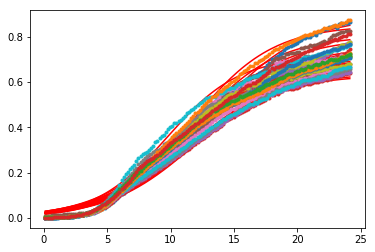

In [245]:
spr_sfit=function_fit(srp['OD600']['time'],srp['OD600']['data'])

plt.plot(srp['OD600']['time'],spr_sfit['evalF'], 'r-')
plt.plot(srp['OD600']['time'],srp['OD600']['data'],'.')
plt.show()

In [ ]:
The functions doesn´t seems really good...

In [247]:
from scipy.interpolate import UnivariateSpline

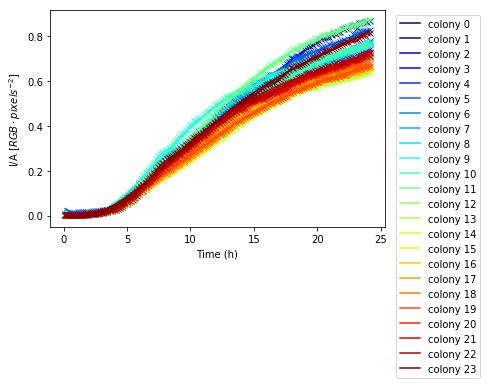

In [268]:
A_smooth={}

wells_srp= srp['OD600']['data'].shape[1]
colors = plt.cm.jet(np.linspace(0, 1, wells_srp))

for i, c in zip(range(wells_srp), colors):
    A_smooth[i] = UnivariateSpline(srp['OD600']['time'],srp['OD600']['data'][:,i], k=4)   # k is the degree of the smoothing spline  (<=5)
    A_smooth[i].set_smoothing_factor(10)
    plt.plot(srp['OD600']['time'],A_smooth[i](srp['OD600']['time']),'-',color=c, label='colony '+str(i))
    plt.plot(srp['OD600']['time'],srp['OD600']['data'][:,i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

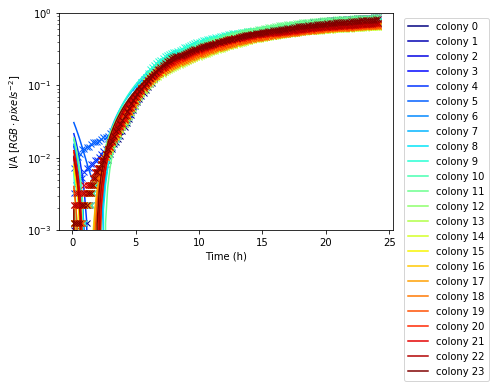

In [273]:
for i, c in zip(range(wells_srp), colors):
    plt.plot(srp['OD600']['time'],A_smooth[i](srp['OD600']['time']),'-',color=c, label='colony '+str(i))
    plt.plot(srp['OD600']['time'],srp['OD600']['data'][:,i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.yscale('log')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.ylim([0.001,1])
plt.show()

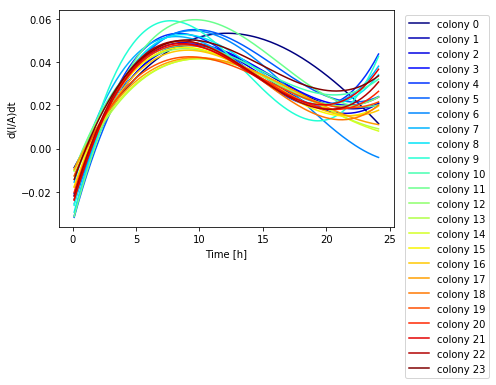

In [271]:
dAdt={}

for i, c in zip(range(wells_srp), colors):
    dAdt[i]=A_smooth[i].derivative() 
    
    plt.plot(srp['OD600']['time'],dAdt[i](srp['OD600']['time']),'-',color=c, label='colony '+str(i))
    #plt.plot(srp['OD600']['time'],srp['OD600']['data'][:,i],'x',color=c)
    plt.xlabel('Time [h]')
    plt.ylabel('d(I/A)dt')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [ ]:
for i, c in zip(range(wells_srp), colors):
    dAdt[i]=A_smooth[i].derivative() 
    
    plt.plot(srp['OD600']['time'],dAdt[i](srp['OD600']['time']),'-',color=c, label='colony '+str(i))
    #plt.plot(srp['OD600']['time'],srp['OD600']['data'][:,i],'x',color=c)
    plt.xlabel('Time [h]')
    plt.ylabel('d(I/A)dt')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [209]:
def plot_group(wsd, wsl, datasheets, index_data, index_label, label_cath, y_axis_labels, log = False):
    """
    Plot the data from 'wsd' of wells indicated on 'index_data' putting the labels from 'label_cath' whos positions
    are indicated in 'index_label'.  
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    wsl:dictionary
        contain the labels of each well
        
    datasheets: list
        list of datasheet names. If you only put one name, make sure to make it a list
        e.g. ['sheet_name'] and not only 'sheetname'
    
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    index_label: list
        coordinates of the selected wells in the label sheets
        can be obtained with get_group_index or set manually
    
    label_cath: list
        sheet names of the cathegories to use in the labels
    
    y_axis_labels: list
        y axis labels to write in the plots. It have to be in the same order
        as the data is included. 
        e.g: y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']
        
    
    Returns
    -------
    Plots of the desired data
        
    """
        
    data = {}
    labels = []
    ind_len = len(index_data)
    
    for name in datasheets:
        # make a list with arrays of zeros with the size of each dataset
        data[name] = np.zeros((wsd[name]['time'].shape[0], ind_len))

        # assign the corresponding values to each array
        for i in range(ind_len):
            data[name][:,i]=wsd[name]['data'][:,index_data[i]]
            
            # get the labels of the selected wells - datasets
            labels.append(get_labelstrings(wsl, index_label, i, label_cath))   
        
    print(labels)
    # make a list of non-redundant labels
    nr_labels = non_redundant_list(labels)

    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    # make plots
   
    for name,m in zip(datasheets, range(len(y_axis_labels))):
        fig= plt.figure()
        fig.suptitle(name + ' series')
        plot_lines = []
        time=wsd[name]['time']
        
        for j in range(ind_len):
            lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
            p=plt.plot(time, data[name][:,j], color=colors[lab_num])
            plot_lines.append(p)
        
        plt.ylabel(y_axis_labels[m])
        plt.xlabel('Time [hr]')
        if log == True:
            plt.yscale('log')
        #plt.axis([0, 6, 0, 20])
        plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
        plt.show()

In [ ]:
fitf = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errf = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [-15., 0.8, 0., -1.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))

[             nan              nan              nan ...,   7.18142066e+09
   8.20245413e+09   8.35674149e+09]


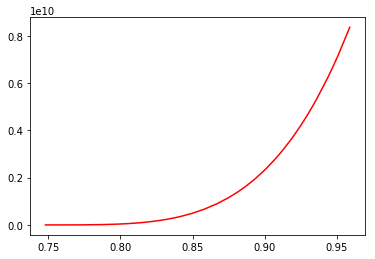

In [416]:
A=FB_sort_dim[:,0]
B=FB_sort_dim[:,1]
z=np.polyfit(A,B,3)
C=np.poly1d(z)

fig= plt.figure()
plt.plot(A,C(A),color='r')
plt.plot(A,B,'x',color='b')
plt.show()


#spline=UnivariateSpline(FB_sort_dim[:,0],FB_sort_dim[:,1], k=1)
spline=UnivariateSpline(Fluo_Blank['OD600']['data'][:,1],Fluo_Blank['CFP']['data'][:,1], k=4)
spline.set_smoothing_factor(10)
print(spline(FB_sort_dim[:,0][:]))
fig= plt.figure()

#plt.plot(FB_sort_dim[:,0],spline(FB_sort_dim[:,0]),'-',color='r', label='spline')
#plt.plot(FB_sort_dim[:,0],FB_sort_dim[:,1],'x',color='b')
#plt.plot(FB_sort_dim[:,0],FB_sort_dim[:,1],'.')
plt.show()

In [257]:
Fluo_Blank['OD600']['data'].shape[0]

145

In [268]:
data_sheets[1]

'CFP'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11]]
['1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '150.0 , M9 Glicerol', '100.0 , M9 Glicerol', '70.0 , M9 Glicerol', '50.0 , M9 Glicerol', '40.0 , M9 Glicerol', '30.0 , M9 Glicerol', '20.0 , M9 Glicerol', '10.0 , M9 Glicerol', '5.0 , M9 Glicerol', '0.0 , M9 Glicerol', '1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '150.0 , M9 Glicerol', '100.0 , M9 Glicerol', '70.0 , M9 Glicerol', '50.0 , M9 Glicerol', '40.0 , M9 Glicerol', '30.0 , M9 Glicerol', '20.0 , M9 Glicerol', '10.0 , M9 Glicerol', '5.0 , M9 Glicerol', '0.0 , M9 Glicerol', '1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '150.0 , M9 Glicerol', '100.0 , M9 Glicerol', '70.0 , M9 Glicerol', '50.0 , M9 Glicerol', '40.0 , M9 Glicerol', '30.0 , M9 Glicerol', 

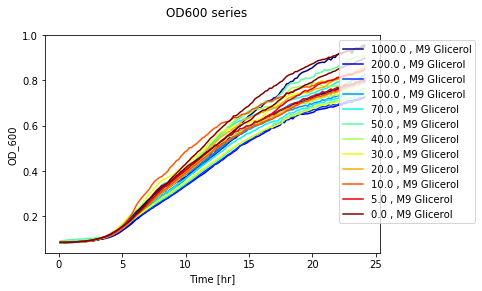

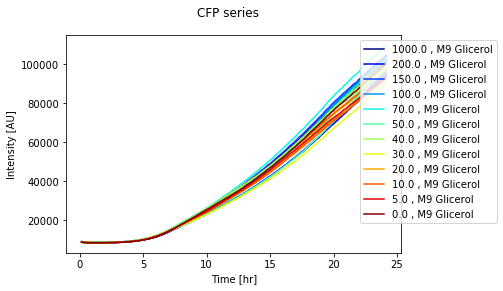

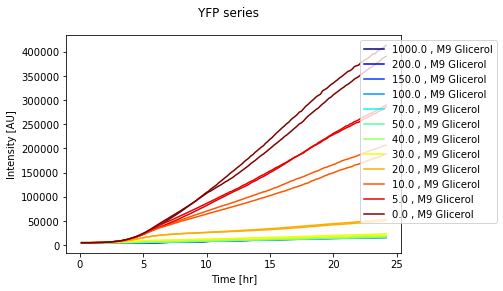

In [157]:
srp_labels=['pSrpR-S3_cyan']  #fill this list manually

# and get the wells index which have that lalbels
index_D, index_L = get_group_index(srp_labels, wlabels, L_sheets)

#Perform the plots of blank series data
legend_labels = [L_sheets[1], L_sheets[2]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdata, wlabels, data_sheets, index_D, index_L, legend_labels, y_axis_labels)

In [ ]:
from scipy.optimize import curve_fit